# Predict Online Customer Intention

#### The project was created by Ahmad Samiee

## Project Overview

This project will predict customers' intention to purchase for an online retail website. This is a classification problem with an imbalanced data where only about 16% of customers purchase and the remaining 84% do not.


## Technical Summary
The metric recall is choosen as the primary metric as this measures how correctly a model can predict those customers who actually purchase. The best model has recall of about 92% where it correctly predicts 92% of all customers who actually purchase.  It also correctly predict the majority (about 70%) of customers who do not.  A second best model has a recall of about 99% but it mis-predicts the majority of customers who do not purchase. 

## Business Problem
An online retailer wants to optimize profit based on visitors intent of purchase. The retailer is setting up a personalized customer experience where a visitor who is identified as some one that will make a purchase may not receive a discount. On the other hand a  visitor who is identified as some one that does not intent on purchasing may be offered a promotional discount to incentivize the visitor to make a purchase.<br>
To predict visitors who actually purchase, the metric recall will be used. Recall takes false negatives (visitors who actually purchase but model predicts they do not) into consideration and therefore is a good measure of model's performance whether it can correctly identify all those visitors whose intention is to purchase.<br>


## Master Dataset
The data comes from University of California Irvine [online_shopper](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset). It consist of about 12,000 records all from different users.  The data has an imbalanced classification where about 16% of visitors purchase while 84% do not.

## EDA, Feature Engineering and Data Processing
Duplicate records were dropped. Created a new column 'mod_Revenue' and converted the boolean values in 'Revenue' column to 0 for 'no purchase' and 1 for 'purchase' using sklearn Label Encoder. The data was split into train(70% of all data) and test(30% of all data)samples and used stratify to maintain the original ratio between majority and minority class.  Using pipes numerical features standardized with sklearn StandardScaler or MinMaxScaler and the categorical features were OneHotEncoded. Used SMOTE on the train sample to correct for classification imbalance. 

In [2]:
# Import libraries needed

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder,MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_regression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix,plot_confusion_matrix 

from xgboost import XGBRFClassifier


%matplotlib inline

In [3]:
# Read 'online_shoppers_intention.csv' file

file = 'data/online_shoppers_intention.csv'
shopper = pd.read_csv(file)
shopper


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False


In [4]:
# Check data types for columns

shopper.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [5]:
# Check any colums has any null

shopper.isna().sum()


Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [6]:
# Check whether any record has duplicates

shopper[shopper.duplicated()]



,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
158,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,3,Returning_Visitor,False,False
159,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,3,2,3,3,Returning_Visitor,False,False
178,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,3,2,3,3,Returning_Visitor,False,False
418,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Mar,1,1,1,1,Returning_Visitor,True,False
456,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Mar,2,2,4,1,Returning_Visitor,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11934,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Dec,1,1,1,2,New_Visitor,False,False
11938,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Dec,1,1,4,1,Returning_Visitor,True,False
12159,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Dec,1,1,1,3,Returning_Visitor,False,False
12180,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Dec,1,13,9,20,Returning_Visitor,False,False


In [7]:
# Drop all duplicated records

shopper.drop(shopper[shopper.duplicated()].index,inplace=True)
shopper.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12205 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12205 non-null  int64  
 1   Administrative_Duration  12205 non-null  float64
 2   Informational            12205 non-null  int64  
 3   Informational_Duration   12205 non-null  float64
 4   ProductRelated           12205 non-null  int64  
 5   ProductRelated_Duration  12205 non-null  float64
 6   BounceRates              12205 non-null  float64
 7   ExitRates                12205 non-null  float64
 8   PageValues               12205 non-null  float64
 9   SpecialDay               12205 non-null  float64
 10  Month                    12205 non-null  object 
 11  OperatingSystems         12205 non-null  int64  
 12  Browser                  12205 non-null  int64  
 13  Region                   12205 non-null  int64  
 14  TrafficType           

Column name: Month
May     3329
Nov     2982
Mar     1860
Dec     1706
Oct      549
Sep      448
Aug      433
Jul      432
June     285
Feb      181
Name: Month, dtype: int64


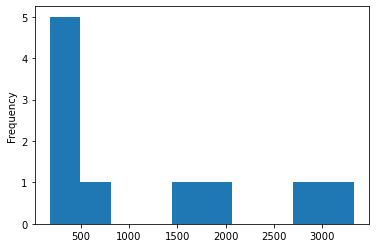

In [8]:
# Identify columns as continous or categorical and spread of data for each feature

# Administrative: categorical value from 0 27, about 5643 records zero 
# Administrative_Duration: continous, about 5778 records with value of zero
# Informational: categorical value from 0 to 16, about 9574 records are zero
# Informational_Duration: continous, about 9800 records are zero
# ProductRelated: continous, max value around 500
# ProductRelated_Duration: continous
# BounceRates: continous, about 5518 records are zero
# ExitRates: continous
# PageValues: continous, about 9475 records are zero
# SpecialDay: categorical, 0, 0.2, 0.4, 0.6, 0.8 and 1, about 10956 records are zero
# Month: categorical, 10 months: Feb,Mar, May, June, Jul, Aug, Sep, Oct, Nov
# OperatingSystems: categorical, about 6541 records have value of 2 (values from 1-8)
# Browser: categorical, about 7883 records have a value of 2 (value from 1-13)
# Region: categorical, (values from 1-9)
# TrafficType: categorical (values fro 1-20)
# VisitorType: categorical, about 10431 records are returning visitors(Returning_visitor, 
#              New_visitor,Other), 
# Weekend: categorical/boolean, about 9346 records weekend false (true or false)
# Revenue: categorical/boolean,target, about 10297 records revenue false (true or false)

column_names = shopper.columns
col_num = 10
print(f'Column name: {column_names[col_num]}')
print(shopper[column_names[col_num]].value_counts())
shopper[column_names[col_num]].value_counts().plot.hist();


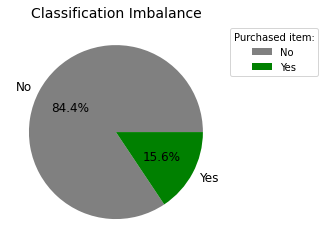

In [9]:
# Show ratios for between purchase and not purchase transaction

fig, axs = plt.subplots()
axs.pie(shopper['Revenue'].value_counts(normalize=True),labels=['No','Yes'],autopct='%1.1f%%',
       colors=['grey','green'],textprops={'fontsize':12});
axs.set_title('Classification Imbalance',fontsize=14);
axs.legend(title='Purchased item:',bbox_to_anchor=(1,1));
#fig.savefig('class_imbalance.jpeg')

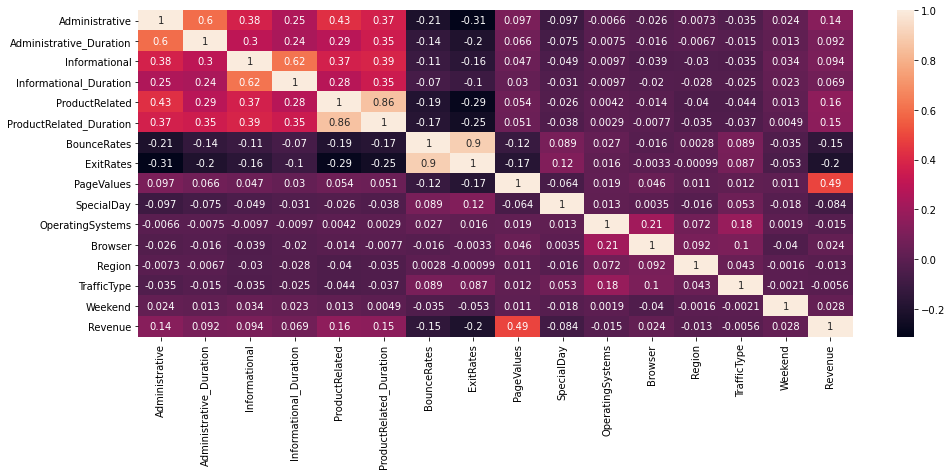

In [10]:
# Check correlation values
# Collinearity between (ProductRelate_Duration,ProductRelated), (ExitRates,BounceRates)

plt.figure(figsize=(16,6))
sns.heatmap(shopper.corr(),annot=True);


In [11]:
# Modify values 'Revenue' column where False is 0 and True is 1

lb = LabelEncoder()
shopper['mod_Revenue'] = lb.fit_transform(shopper['Revenue'])
shopper['mod_Revenue'].value_counts(normalize=True)


0    0.843671
1    0.156329
Name: mod_Revenue, dtype: float64

In [12]:
# Split data into train and test data set
X = shopper.drop(['Revenue','mod_Revenue'],axis=1)
y = shopper['mod_Revenue']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y,
                                                    random_state=4321)

In [13]:
# Scale continues and categorical features 
# Setup numerical and categorical pipeline and incorporate both into
# ColumnTransformer


nums_pipe = Pipeline([('ss',StandardScaler())]) # for continous features option # 1
nums_pipe2 = Pipeline([('mm',MinMaxScaler())]) # for continous features option # 2
cats_pipe = Pipeline([('ohe',OneHotEncoder(sparse=False))])

trans = ColumnTransformer([('nums',nums_pipe,list(X_train.select_dtypes(['int64','float64']))),
                          ('cats',cats_pipe,list(X_train.select_dtypes(['bool','object'])))])

trans2 = ColumnTransformer([('nums2',nums_pipe2,list(X_train.select_dtypes(['int64','float64']))),
                          ('cats',cats_pipe,list(X_train.select_dtypes(['bool','object'])))])

X_train_processed = trans.fit_transform(X_train)  # for continous features with StandardScaler
X_test_processed = trans.transform(X_test)

X_train_processed2 = trans2.fit_transform(X_train) # for cobtinous features with MinMaxScaler
X_test_processed2 = trans2.transform(X_test)


In [14]:
# Incorporate processed X_train and X_test into dataframe

num_col_names = trans.transformers_[0][2] 
cat_col_names = ['x0_Aug','x0_Dec', 'x0_Feb', 'x0_Jul', 'x0_June', 'x0_Mar', 'x0_May', 
                 'x0_Nov','x0_Oct', 'x0_Sep', 'x1_New_Visitor', 'x1_Other',
                 'x1_Returning_Visitor', 'x2_False', 'x2_True']

col_names = num_col_names + cat_col_names

X_train_process_df = pd.DataFrame(X_train_processed,columns=col_names,
                                 index=X_train.index)
X_test_process_df = pd.DataFrame(X_test_processed,columns=col_names,
                                index=X_test.index)

X_train_process_df2 = pd.DataFrame(X_train_processed2,columns=col_names,
                                 index=X_train.index)
X_test_process_df2 = pd.DataFrame(X_test_processed2,columns=col_names,
                                index=X_test.index)


In [15]:
# Correct for classification imbalance with SMOTE

sm = SMOTE(random_state=41,k_neighbors=3)
X_train_sm, y_train_sm = sm.fit_resample(X_train_process_df, y_train) # StandardScaler
X_train_sm2,y_train_sm2 = sm.fit_resample(X_train_process_df2,y_train) # MinMaxScaler


## Feature Selection
Evaluated feature selection to see the noise in the data can be reduced. Data's features were evaluated with sklearn SelectKBest and recursive feature elimination with cross-validation. A method discussed in a paper (Assessing feature selection method performance with class imbalance data, Surani Matharaarachchi et al., Machine Learning with Applications, 2021) was also evaluated a tool for feature selection.<br>
Also compared the data spread for each feature between purchase and no purchase transactions.

In [16]:
# Sort features based specified ranking

def feature_ranking(features,ranking,ascend):
    '''
    Create a list if tuples. Each tuple has two elements - the first is the name of the 
    feature and the second is rank number assigned to the feature. Then sort this list of
    tuples accoring to the assigned ranking where highest ranking feature is at the beginning 
    of the list. Return sorted list.
    '''
    
    ranking_list = [(features[i],ranking[i]) for i in range(len(features))]
    rankings_sorted = sorted(ranking_list, key=lambda x: x[1], reverse=ascend)
    return rankings_sorted

# Plot features 

def plot_feature_ranking(rankings,title,scale=None,filename=None):
    '''
    Create a horizontal bar plot for parameter 'rankings' which is an ordered list of tuples
    where the first element in each tuple is the feature name and second element is its 
    ranking.  Assign title of plot and there is option to change x scale to log. 
    '''
    col_names = [name[0] for name in rankings]
    values = [val[1] for val in rankings]
    
    fig, axs = plt.subplots(figsize=(12,8))
    plot = sns.barplot(x=values,y=col_names, orient='h')
    plot.set_title(title,fontsize=16)
    plot.set_yticklabels(labels=col_names)
    if scale == 'log': plot.set_xscale('log')
    
    #fig.savefig(filename)
        

In [17]:
# Feature selection/evaluation based on filter method SelectKBest with f_regression (method # 1)

kbest = SelectKBest(score_func=f_regression,k='all')
fit = kbest.fit(X_train_process_df2,y_train)

kbest_ranking = feature_ranking(X_train_process_df2.columns,fit.scores_,True)


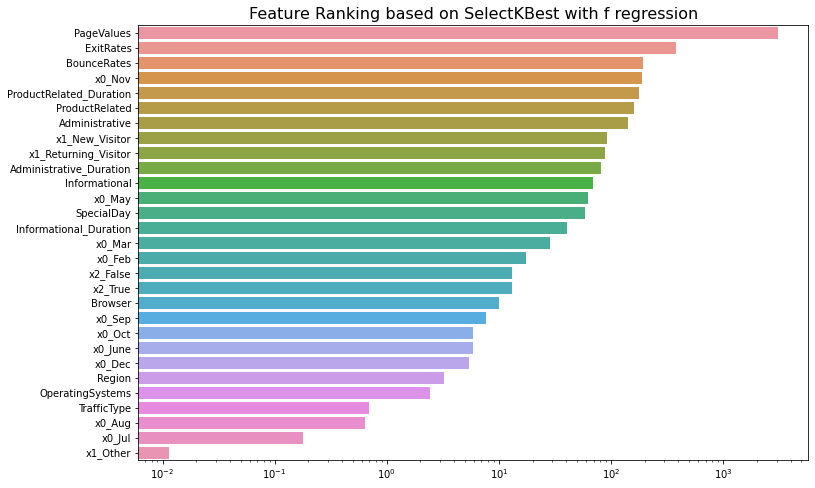

In [18]:
plot_feature_ranking(kbest_ranking,'Feature Ranking based on SelectKBest with f regression',
                     'log','selectkbest.jpeg')

Optimal number of features : 2


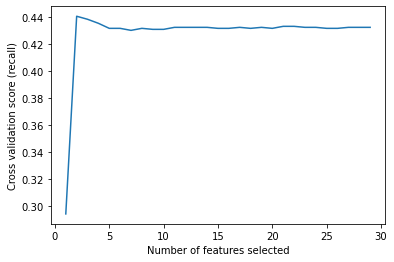

In [19]:
# Feature selection/evaluation based on wrapper method Recursive feature elimination with 
# cross-validation (RFECV) using SVC as estimator (method # 2)

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel='linear',random_state=43)


min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(3),
    scoring="recall",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train_process_df, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (recall)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
);


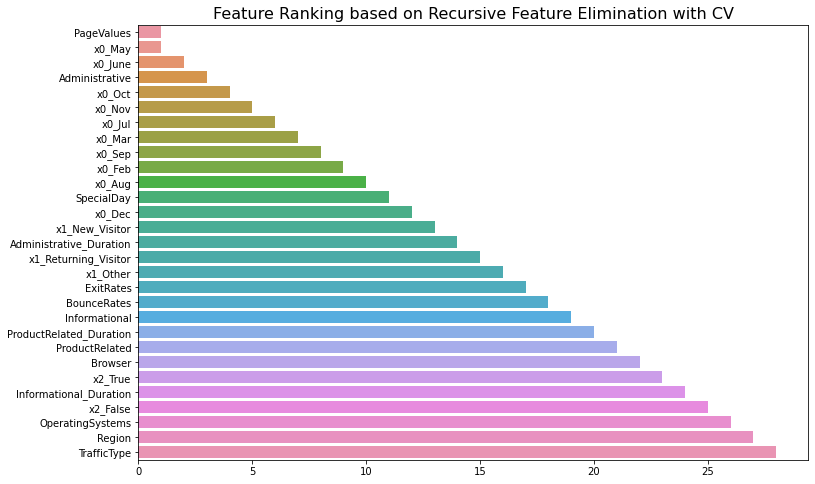

In [20]:
# Feature ranking based RFECV
rfecv_ranking = feature_ranking(X_train_process_df.columns,rfecv.ranking_,False)
plot_feature_ranking(rfecv_ranking,'Feature Ranking based on Recursive Feature Elimination with CV',
                    None,'rfecv.jpeg')

In [21]:
# Feature selection / evaluation based on summation of the absolute values of principal
# component loadings (method # 3)

pca = PCA(n_components=0.9,random_state=44)
pca.fit(X_train_process_df)

loadings = pd.DataFrame(
    data=abs(pca.components_.T) * pca.explained_variance_,
    columns=[f'PC{i}' for i in range(1, len(pca.explained_variance_) + 1)],
    index=X_train_process_df.columns
)

loadings['Abs_Sum'] = loadings.apply(lambda x: x.sum(),axis=1)
loadings.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,Abs_Sum
Administrative,1.306911,0.087848,0.033634,0.251698,0.341420,0.323682,0.019569,0.051066,0.074670,0.013341,0.259254,0.032881,2.795974
Administrative_Duration,1.098764,0.147982,0.040586,0.353993,0.381991,0.444105,0.027981,0.080964,0.103885,0.005097,0.237812,0.022907,2.946068
Informational,1.208820,0.491132,0.052973,0.150456,0.467485,0.052324,0.025914,0.025711,0.036302,0.006720,0.101321,0.022361,2.641517
Informational_Duration,1.003595,0.513488,0.063819,0.158927,0.618819,0.049383,0.030129,0.034139,0.028565,0.008270,0.091619,0.022778,2.623530
ProductRelated,1.406086,0.275269,0.077526,0.384336,0.243425,0.334575,0.020802,0.096352,0.027258,0.018691,0.018865,0.002260,2.905448


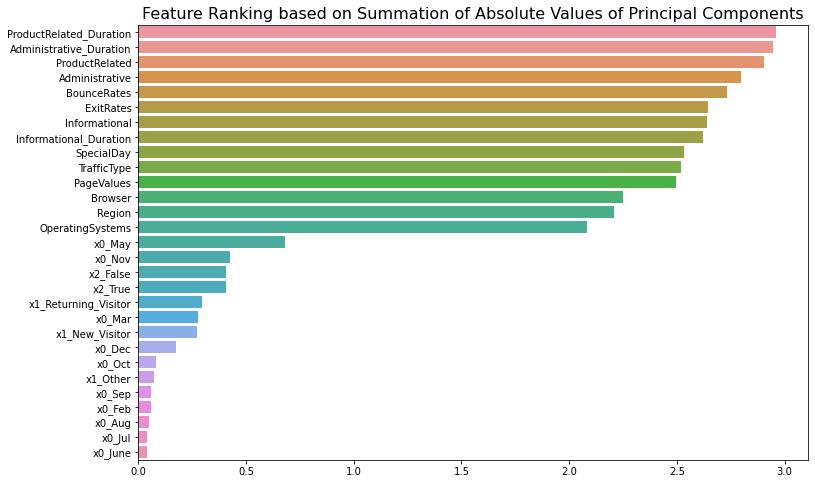

In [22]:
# Feature ranking based on summation of bbsolute values of principal components

pca_ranking = feature_ranking(list(loadings.index),
                              list(loadings['Abs_Sum']),True)

plot_feature_ranking(pca_ranking,
                     'Feature Ranking based on Summation of Absolute Values of Principal Components',
                    None,'savpcl.jpeg')


In [23]:
# Split records whether customer purchased (pos_df) and not purchase (neg_df)
# And keep feature spread between -6 and 6

bool_train_labels = y_train != 0
pos_df = X_train_process_df[ bool_train_labels].clip(-6,6)
neg_df = X_train_process_df[~bool_train_labels].clip(-6,6)

In [24]:

column_names = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'x0_Aug',
       'x0_Dec', 'x0_Feb', 'x0_Jul', 'x0_June', 'x0_Mar', 'x0_May', 'x0_Nov',
       'x0_Oct', 'x0_Sep', 'x1_New_Visitor', 'x1_Other',
       'x1_Returning_Visitor', 'x2_False', 'x2_True']



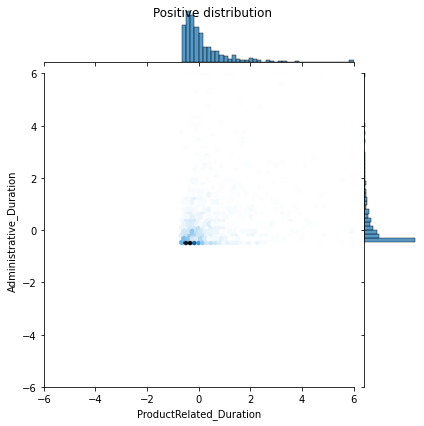

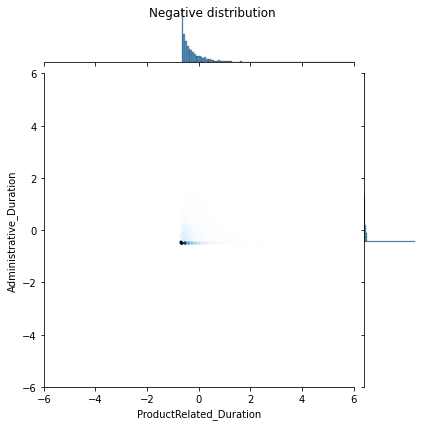

In [25]:
# Look at feature spread for positive(purchase occured) and negative transactions
col1 = column_names[5]
col2 = column_names[1]

sns.jointplot(x=pos_df[col1], y=pos_df[col2],
              kind='hex', xlim=(-6,6), ylim=(-6,6))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df[col1], y=neg_df[col2],
              kind='hex', xlim=(-6,6), ylim=(-6,6))
_ = plt.suptitle("Negative distribution")


# Prediction Models
The processed data was evaluated with following prediction models:<br>
* DummyClassifier as base model
* Multinomial Naive Bay as a basic model
* Logistic Regression trained with SMOTE samples
* Logistic Regression where threshhold adjusted to take into account for classification imbalance
* Multi-layer Perceptron classifier trained with SMOTE samples
* XGB Random Forest Classifier trained with SMOTE
* XGB Random Forest Classifier where classification imbalance adjusted through models hyperparameter (1st and 2nd best models)

Use sklearn GridSearchCV to tune models.

In [26]:
# Display validation results for train sample

def display_validation_results(results,model_name,train_time):
    '''
    Retrieve validation metrics and print them out.
    '''
    
    v_recall = results['mean_test_recall'].mean()
    v_accuracy = results['mean_test_accuracy'].mean()
    v_precision = results['mean_test_precision'].mean()
    
    print('='*60)
    print(f'Validation results for: {model_name}')
    print(f'Recall: {v_recall}\nAccuracy: {v_accuracy}\nPrecision: {v_precision}')
    stop_time = time.time()
    print(f'\nTraining time for {model_name} took {train_time} seconds.\n')


In [27]:
# Display prediction results for test sample

def display_test_predictions(actuals, predictions, model_name):
    '''
    Calculate metrics for test samples and print them out.
    '''
    
    t_recall = recall_score(actuals, predictions)
    t_accuracy = accuracy_score(actuals,predictions)
    t_precision = precision_score(actuals,predictions)
    
    print(f'Test sample predictions result for: {model_name}')
    print(f'Recall: {t_recall}\nAccuracy: {t_accuracy}\nPrecision: {t_precision}\n')
    

In [28]:
# Display confusion matrix and ROC plot

def display_plots(y_actuals,y_predictions,model_name,model_list):
    '''
    Create the following plots:
    
    1.Confusion Matrix:
    Compute confusion matris based on y_actuals and y_predictions and then plot.
    
    2. ROC Plot:
    Compute auc for each model and plot curves in one plot.
    '''
    # Confusion matrix
    conf_matrix = confusion_matrix(y_actuals, y_predictions)
    
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10))
    #fig, ax1 = plt.subplots(figsize=(6,6))
    
    ax1.matshow(conf_matrix, cmap=plt.cm.Greens, alpha=0.3)
    
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax1.text(x=j,y=i, s=conf_matrix[i, j],va='center',ha='center',size='xx-large')
 
    ax1.set_xlabel('Predictions',fontsize=12)
    ax1.set_ylabel('Actuals',fontsize=12)
    ax1.xaxis.set_ticks_position('bottom')
    ax1.set_title(f'Confusion Matrix for: {model_name}',fontsize=14);
    
      
    # ROC Curve
    model_names = [model[2] for model in model_list]
    
    if model_name not in model_names:
        model_list.append((y_actuals,y_predictions,model_name))
    
    for model in model_list:
        fpr, tpr, _ = metrics.roc_curve(model[0], model[1])
        auc = metrics.roc_auc_score(model[0], model[1])
        name_auc = model[2] + ' AUC: ' + format(auc,'0.2f')          
        ax2.plot(fpr,tpr,label=name_auc)
        ax2.set_title('ROC Plot',fontsize=14)
        ax2.set_xlabel('False Positive Rate',fontsize=12)
        ax2.set_ylabel('True Positive Rate',fontsize=12)
        ax2.legend()
        
    plt.tight_layout(pad=1.1)  
    plt.show()


In [29]:


def show_results(model,model_name,train_time,y_actuals,y_predictions,model_list):
    '''
    Call functions to show validation and prediction results and also display visuals like
    confusion matrix and ROC cuve.
    '''
    
    display_validation_results(model.cv_results_,model_name,train_time)
    display_test_predictions(y_actuals, y_predictions, model_name)
    display_plots(y_actuals,y_predictions,model_name,model_list)
    

In [30]:
# DummyClassifier
# Incorporate DummyClassifier it into GridSearchCV
# Train model with SMOTE classification corrected data

start = time.time()


base_grid_search = GridSearchCV(estimator=DummyClassifier(),
                                param_grid= {'random_state' : [1234],
                                            'strategy' : ['prior']},
                                refit='recall', 
                                scoring=['recall','accuracy','precision'])

# Train model and predict for test samples
base_grid_search.fit(X_train_sm,y_train_sm)
base_y_test_pred = base_grid_search.predict(X_test_process_df)
model_name = 'DummyClassifier'

stop = time.time()

/Users/ahmadsamiee/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation results for: DummyClassifier
Recall: 0.4
Accuracy: 0.49986125563648975
Precision: 0.1999306278182449

Training time for DummyClassifier took 0.06459379196166992 seconds.

Test sample predictions result for: DummyClassifier
Recall: 0.0
Accuracy: 0.843801201529219
Precision: 0.0



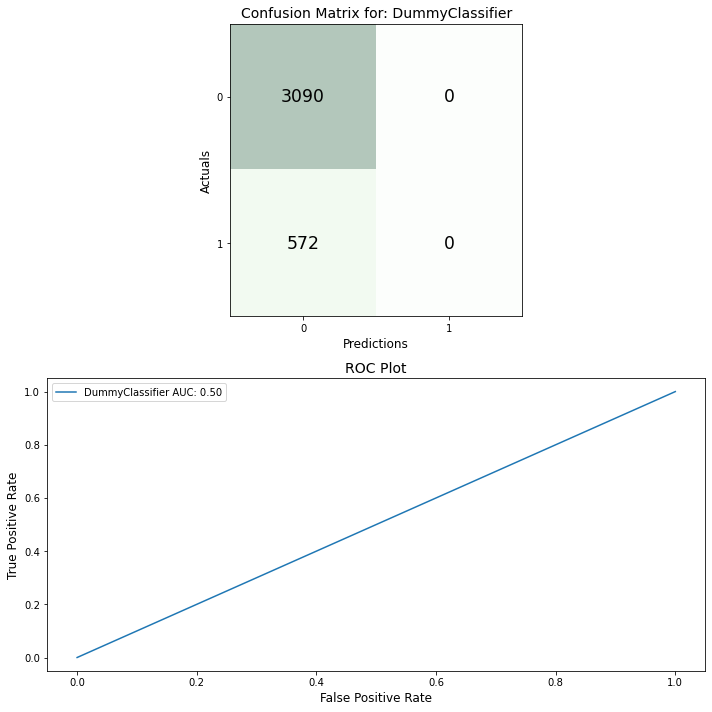

In [31]:
# Display results

models = []
show_results(base_grid_search,
             model_name,
             stop-start,
             y_test,
             base_y_test_pred,
             models)


In [32]:
# MultinomialNB
# Incorporate it MultinomialNB into GridSearchCV
# Train model with SMOTE classification corrected data

start = time.time()


mn_grid_search = GridSearchCV(estimator=MultinomialNB(),
                                param_grid= {'alpha' : [1.0]},
                                refit='recall', 
                                scoring=['recall','accuracy','precision'])

# Train model
mn_grid_search.fit(X_train_sm2,y_train_sm2) # X_train_process2_df is scaled with min_max
model_name2 = 'MultinomialNB'

stop = time.time()


Validation results for: MultinomialNB
Recall: 0.7388647889574296
Accuracy: 0.6871091706798786
Precision: 0.6697390364037293

Training time for MultinomialNB took 0.1291790008544922 seconds.

Test sample predictions result for: MultinomialNB
Recall: 0.756993006993007
Accuracy: 0.6572910977607864
Precision: 0.27953518398967075



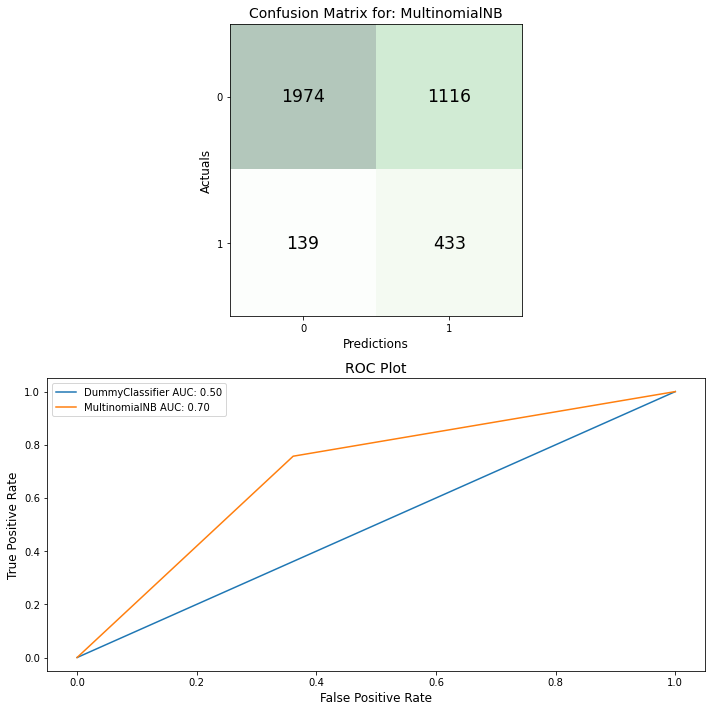

In [33]:
# Predict for X_test samples and display results

mn_y_test_pred = mn_grid_search.predict(X_test_process_df2)

show_results(mn_grid_search,
             model_name2,
             stop-start,
             y_test,
             mn_y_test_pred,
             models)


In [34]:
# LogisticRegression with SMOTE sample balance
# Incorporate LogisticRegression into GridSearchCV
# Train model with SMOTE classification corrected data

start = time.time()

lr_grid_search = GridSearchCV(estimator=LogisticRegression(),
                                param_grid= {'random_state' : [2345],
                                            'C': [1,100,1000],  
                                            'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
                                            'max_iter' : [1000,5000]},
                                refit='recall', 
                                scoring=['recall','accuracy','precision'])

# Train model
lr_grid_search.fit(X_train_sm,y_train_sm)
model_name3 = 'LogisticRegression'

stop = time.time()


In [35]:
lr_grid_search.best_params_

{'C': 1, 'max_iter': 1000, 'random_state': 2345, 'solver': 'newton-cg'}

Validation results for: LogisticRegression
Recall: 0.787570787867238
Accuracy: 0.8274059032469085
Precision: 0.8558218355292216

Training time for LogisticRegression took 12.7442786693573 seconds.

Test sample predictions result for: LogisticRegression
Recall: 0.75
Accuracy: 0.84598580010923
Precision: 0.5047058823529412



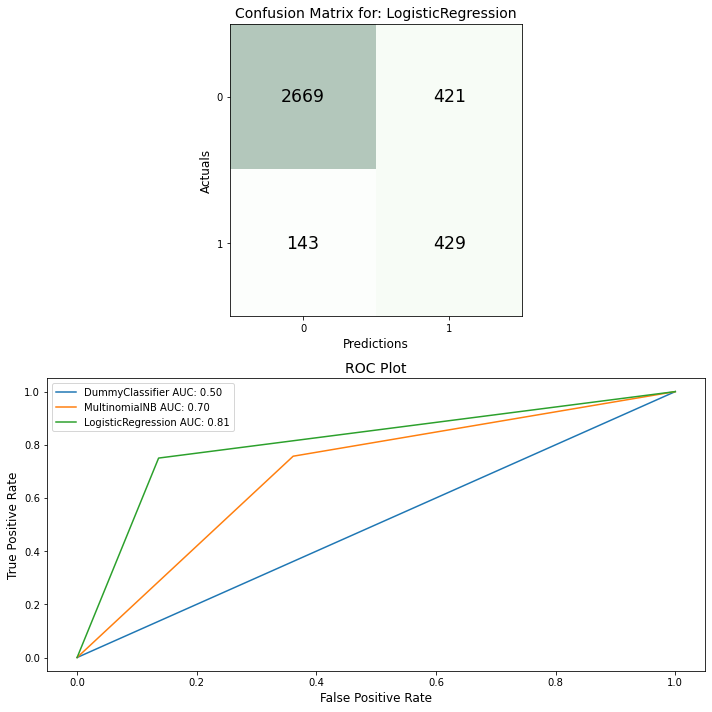

In [36]:
# Predict for X_test samples and display results

lr_y_test_pred = lr_grid_search.predict(X_test_process_df)


show_results(lr_grid_search,
             model_name3,
             stop-start,
             y_test,
             lr_y_test_pred,
             models)

In [37]:
# LogisticRegression with threshhold adjustment
# Incoporate LogisticRegression into GridSearchCV
# Train model with unbalanced data (x_train_proccess_df)

start = time.time()

lr_grid_search2 = GridSearchCV(estimator=LogisticRegression(),
                                param_grid= {'random_state' : [2345],
                                            'C': [1,100,1000],  
                                            'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
                                            'max_iter' : [1000,5000],
                                            'class_weight' : ['balanced']},
                                refit='recall', 
                                scoring=['recall','accuracy','precision'])

# Train model
lr_grid_search2.fit(X_train_process_df,y_train)
model_name4 = 'LogisticRegression_v2'

stop = time.time()


In [38]:
lr_grid_search2.best_params_

{'C': 1,
 'class_weight': 'balanced',
 'max_iter': 1000,
 'random_state': 2345,
 'solver': 'newton-cg'}

Validation results for: LogisticRegression_v2
Recall: 0.7609561431295458
Accuracy: 0.856908330132054
Precision: 0.5306153951687365

Training time for LogisticRegression_v2 took 6.853827953338623 seconds.

Test sample predictions result for: LogisticRegression_v2
Recall: 0.9947552447552448
Accuracy: 0.4841616602949208
Precision: 0.23177189409368634



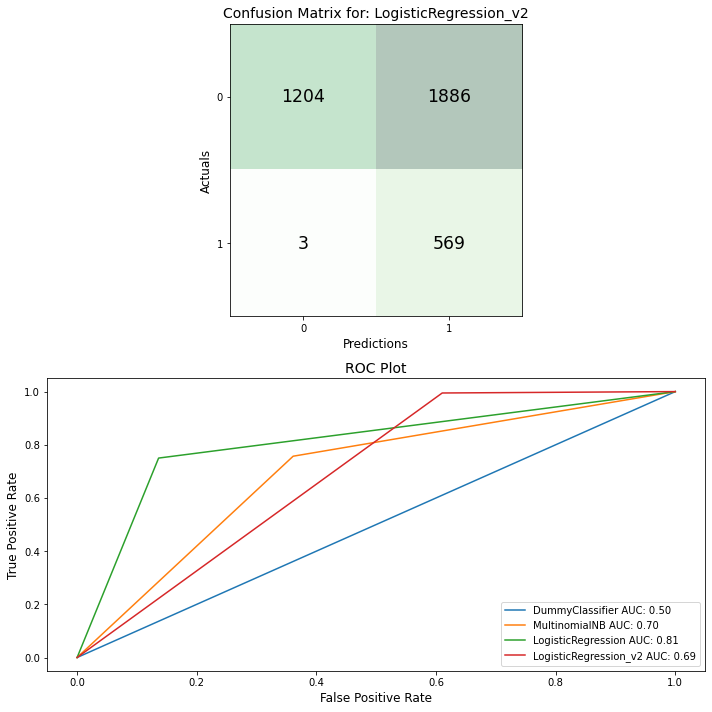

In [39]:
# Set threshhold according to data's minority class (number of minority divide by total)

threshhold = y.value_counts()[1]/len(y)

lr_y_test_pred2 = np.where(
    lr_grid_search2.predict_proba(X_test_process_df)[:,1] > threshhold,1,0)


show_results(lr_grid_search2,
             model_name4,
             stop-start,
             y_test,
             lr_y_test_pred2,
             models)

In [40]:
# MLPClassifier with SMOTE sample balance
# Incorporate MLPClassifier into GridSearchCV
# Train model with SMOTE classification corrected data

start = time.time()

mlp_grid_search = GridSearchCV(estimator=MLPClassifier(),
                                param_grid= {'random_state' : [6786],
                                             'hidden_layer_sizes' : [(5,3)], # tried (300,150,50),(10,3),(300,),(600,),(100,)
                                             'activation' : ['relu'],  # tried 'identity', 'logistic', 'tanh', 'relu'
                                             'max_iter' : [2000],
                                             'solver' : ['adam'], # tried 'lbfgs', 'sgd', 'adam'
                                             'alpha' : [0.0001], # tried 0.0001, 0.001
                                             'learning_rate' : ['constant'] # tried 'constant', 'invscaling', 'adaptive'
                                             },
                                refit='recall', 
                                scoring=['recall','accuracy','precision'])

# Train model
mlp_grid_search.fit(X_train_sm,y_train_sm)
model_name5 = 'MLPClassifier'

stop = time.time()


In [41]:
mlp_grid_search.best_params_

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (5, 3),
 'learning_rate': 'constant',
 'max_iter': 2000,
 'random_state': 6786,
 'solver': 'adam'}

Validation results for: MLPClassifier
Recall: 0.8991298037173678
Accuracy: 0.8758153939326542
Precision: 0.859220131938482

Training time for MLPClassifier took 63.14605689048767 seconds.

Test sample predictions result for: MLPClassifier
Recall: 0.8321678321678322
Accuracy: 0.8547241944292736
Precision: 0.5219298245614035



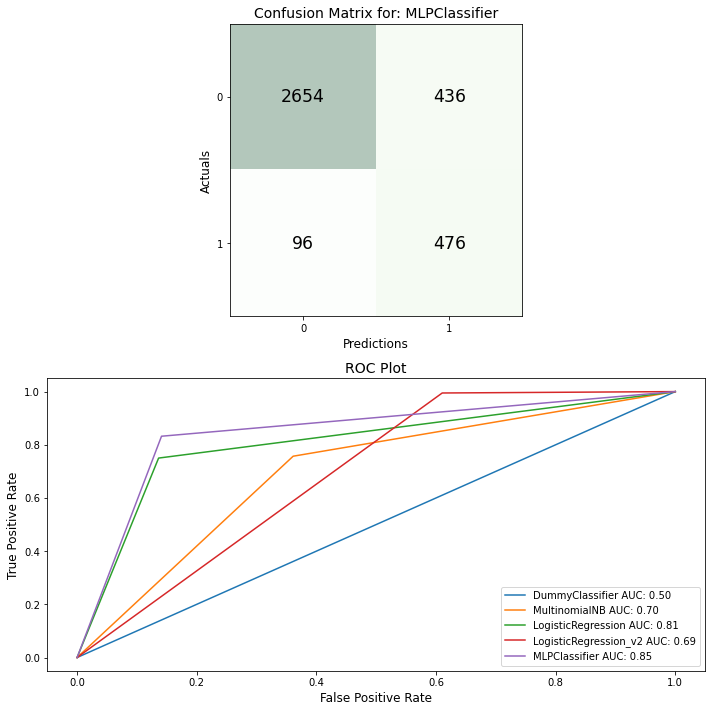

In [42]:
mlp_y_test_pred = mlp_grid_search.predict(X_test_process_df)

show_results(mlp_grid_search,
             model_name5,
             stop-start,
             y_test,
             mlp_y_test_pred,
             models)

In [43]:
# XGBRFClassifier
# Incoporate XGBRFClassifier into GridSearchCV
# Train model with SMOTE classification corrected data

start = time.time()

xgbrf_grid_search_1 = GridSearchCV(estimator=XGBRFClassifier(),
                                param_grid= {'random_state' : [2345],
                                             'n_estimators' : [100],  # tried 10,100,1000
                                             'max_depth' : [3],  # tried 3,11,21,31
                                             'subsample' : [0.5], # tried 0. and 1
                                             'learning_rate' : [0.5],  # tried 0.5 and 1
                                             'lambda' : [1], # tied 1 and 10
                                             'gamma' : [1],   # tried 1nd 10
                                             'subsample' : [1],
                                             'max_delta_step' : [0.6],
                                             'colsample_bytree' : [0.5], # 0.5 gives a recall of 0.99
                                             'scale_pos_weight' : [1]
                                            },
                                refit='recall', 
                                scoring=['recall','accuracy','precision'])

# Train model
xgbrf_grid_search_1.fit(X_train_sm,y_train_sm)
model_name6 = 'XGBRFClassifier'

stop = time.time()


In [44]:

xgbrf_grid_search_1.best_params_

{'colsample_bytree': 0.5,
 'gamma': 1,
 'lambda': 1,
 'learning_rate': 0.5,
 'max_delta_step': 0.6,
 'max_depth': 3,
 'n_estimators': 100,
 'random_state': 2345,
 'scale_pos_weight': 1,
 'subsample': 1}

Validation results for: XGBRFClassifier
Recall: 0.8722130089579879
Accuracy: 0.8776196002169264
Precision: 0.8816967287950425

Training time for XGBRFClassifier took 2.320683002471924 seconds.

Test sample predictions result for: XGBRFClassifier
Recall: 0.798951048951049
Accuracy: 0.8705625341343528
Precision: 0.5600490196078431



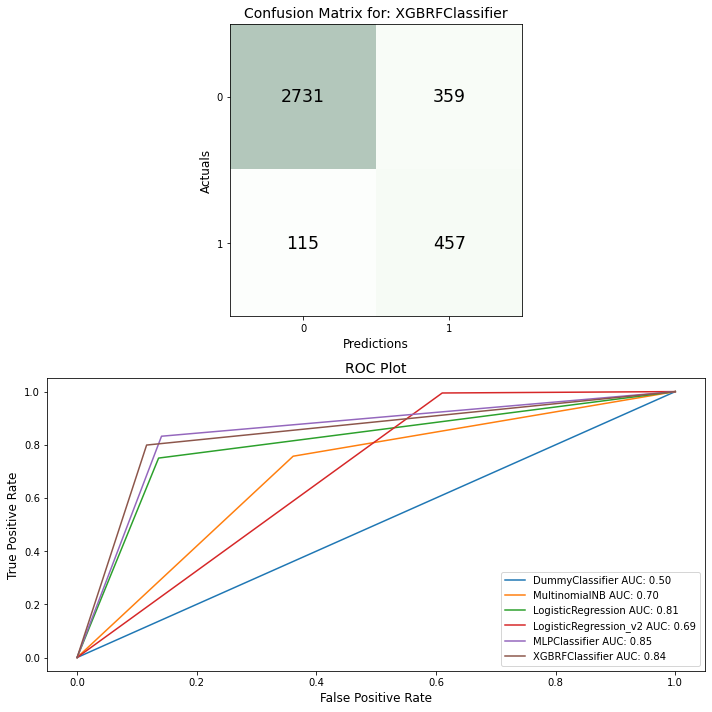

In [45]:
xgbrf_y_test_pred_1 = xgbrf_grid_search_1.predict(X_test_process_df)

xgbrf_models = [(y_test,xgbrf_y_test_pred_1,model_name6)]

show_results(xgbrf_grid_search_1,
             model_name6,
             stop-start,
             y_test,
             xgbrf_y_test_pred_1,
             models)

#### Best Model

In [46]:
# XGBRFClassifier
# Incorporate XGBClassifier into GridSearchCV
# Adjusted for classification imbalance through scale_pos_weight hyperparameter
# Train model with imbalanced dataset (X_train_process_df)

start = time.time()

xgbrf_grid_search_2 = GridSearchCV(estimator=XGBRFClassifier(),
                                param_grid= {'random_state' : [2345],
                                             'n_estimators' : [100],  # tried 10,100,1000
                                             'max_depth' : [3],  # tried 3,11,21,31
                                             'subsample' : [0.5], # tried 0. and 1
                                             'learning_rate' : [0.5],  # tried 0.5 and 1
                                             'lambda' : [1], # tied 1 and 10
                                             'gamma' : [1],   # tried 1nd 10
                                             'subsample' : [1],
                                             'max_delta_step' : [0.6],
                                             'colsample_bytree' : [0.5], # 0.5 gives a recall of 0.99
                                             'scale_pos_weight' : [11]
                                            },
                                refit='recall', 
                                scoring=['recall','accuracy','precision'])

# Train model
xgbrf_grid_search_2.fit(X_train_process_df,y_train)
model_name7 = 'XGBRFClassifier_v2'

stop = time.time()


In [47]:

xgbrf_grid_search_2.best_params_

{'colsample_bytree': 0.5,
 'gamma': 1,
 'lambda': 1,
 'learning_rate': 0.5,
 'max_delta_step': 0.6,
 'max_depth': 3,
 'n_estimators': 100,
 'random_state': 2345,
 'scale_pos_weight': 11,
 'subsample': 1}

Validation results for: XGBRFClassifier_v2
Recall: 0.9214181899491306
Accuracy: 0.7415442148811294
Precision: 0.3695561792604274

Training time for XGBRFClassifier_v2 took 1.1832687854766846 seconds.

Test sample predictions result for: XGBRFClassifier_v2
Recall: 0.9213286713286714
Accuracy: 0.7329328235936646
Precision: 0.36095890410958903



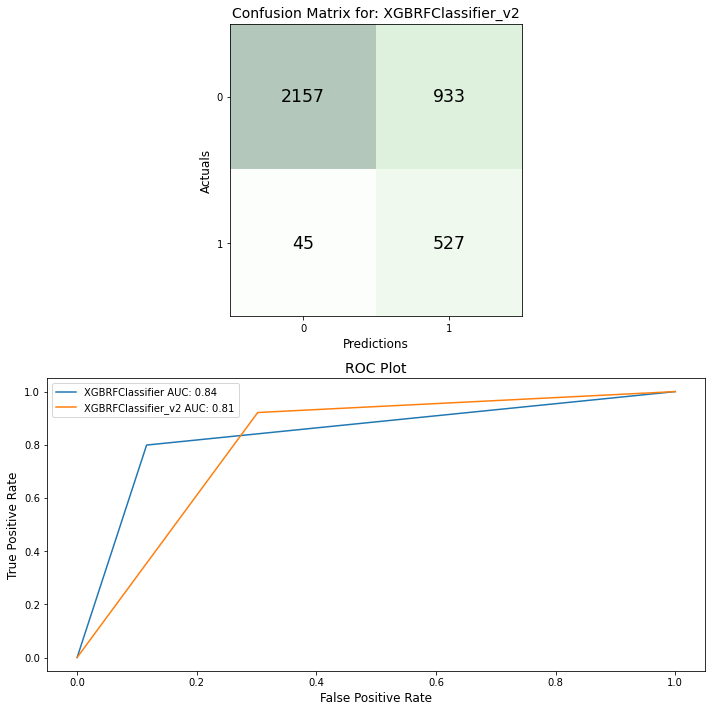

In [48]:
xgbrf_y_test_pred_2 = xgbrf_grid_search_2.predict(X_test_process_df)

show_results(xgbrf_grid_search_2,
             model_name7,
             stop-start,
             y_test,
             xgbrf_y_test_pred_2,
             xgbrf_models)

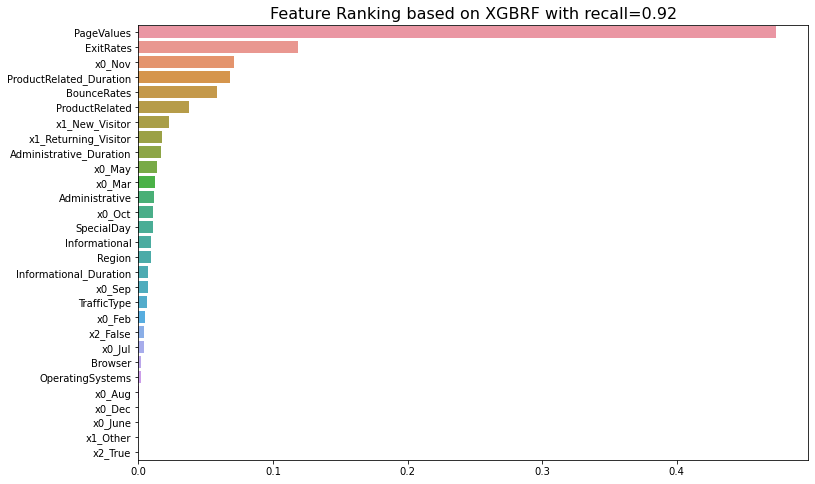

In [49]:
# Show feature importance for best model 

xgbrf_ranking = feature_ranking(X_train_process_df.columns,
                                xgbrf_grid_search_2.best_estimator_.feature_importances_,True)
plot_feature_ranking(xgbrf_ranking,'Feature Ranking based on XGBRF with recall=0.92',
                    None,'xgbrf.jpeg')

#### Second Best Model

In [50]:
# XGBRFClassifier
# Incorporate XGBRFClassifier into GridSearchCV
# Adjusted for classification imbalance through scale_pos_weight hyperparameter 
# Gives highest recall when scale_pos_weight set at 27

# Train model imbalanced dataset (X_train_process_df)

start = time.time()

xgbrf_grid_search_3 = GridSearchCV(estimator=XGBRFClassifier(),
                                param_grid= {'random_state' : [2345],
                                             'n_estimators' : [100],  # tried 10,100,1000
                                             'max_depth' : [3],  # tried 3,11,31
                                             'subsample' : [0.5], # tried 0. and 1
                                             'learning_rate' : [0.5],  # tried 0.5 and 1
                                             'lambda' : [1], # tied 1 and 10
                                             'gamma' : [1],   # tried 1nd 10 
                                             'subsample' : [1],
                                             'max_delta_step' : [0.6],
                                             'colsample_bytree' : [0.5],
                                             'scale_pos_weight' : [27]
                                            },
                                refit='recall', 
                                scoring=['recall','accuracy','precision'])

# Train model
xgbrf_grid_search_3.fit(X_train_process_df,y_train)
model_name8 = 'XGBRFClassifier_v3'

stop = time.time()


In [51]:

xgbrf_grid_search_3.best_params_

{'colsample_bytree': 0.5,
 'gamma': 1,
 'lambda': 1,
 'learning_rate': 0.5,
 'max_delta_step': 0.6,
 'max_depth': 3,
 'n_estimators': 100,
 'random_state': 2345,
 'scale_pos_weight': 27,
 'subsample': 1}

Validation results for: XGBRFClassifier_v3
Recall: 0.9932640169936832
Accuracy: 0.32038162750447763
Precision: 0.18638909116988134

Training time for XGBRFClassifier_v3 took 1.2086091041564941 seconds.

Test sample predictions result for: XGBRFClassifier_v3
Recall: 0.9982517482517482
Accuracy: 0.3230475150191152
Precision: 0.1872745162348311



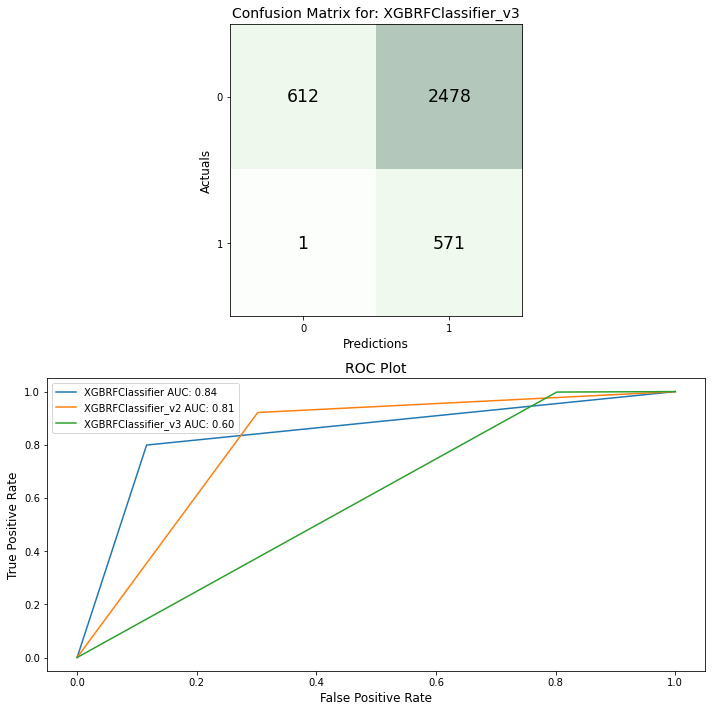

In [52]:
xgbrf_y_test_pred_3 = xgbrf_grid_search_3.predict(X_test_process_df)

show_results(xgbrf_grid_search_3,
             model_name8,
             stop-start,
             y_test,
             xgbrf_y_test_pred_3,
             xgbrf_models)

# Conclusion
The basic model, Multinomial Naive Bay, has a recall of about 0.76 and accuracy of 0.66.  Logistic Regression model trained with SMOTE classification corrected training data has a recall of about 0.75 and improved accuracy score of about 0.85. Adjusting Logistic Regression model threshhholf to about 0.15 to take into consideration classification imbalance increases recall to about 0.99 and is accuracy reduced to 0.48. MLPClassifier trained with SMOTE classification corrected training data has a recall of about 0.83 and accuracy of 0.85.  XGBRFClassifier trained with SMOTE classification corrected training data has recall of 0.80 and accuracy of 0.87. Adjusting XGBRFClassifier hyperparameter scale_pos_weight improved recall to 0.92 and reduced accuracy to 0.73.  Adjusting this hyperperameter further increases recall to 0.99 and reduced accuracy to 0.32.<br>
Feature selection methods SelectKBest, recursive feature elimination and a method discussed in a data science paper called in this notebook summation of absolute values of principal components are evaluated. It appears SelectKBest method provides the most similar feature ranking to XGBRFClassifier model that has recall of about 0.92.  Adjusting models hyperparameter scale_pos_weight to increase recall to 0.99 changes the feature ranking.  This suggest feature ranking may be model dependent.<br>
The metric recall is choosen as the primary metric as this measures how correctly a model can predict those customers who actually purchase. The best model has a recall of about 92% where it correctly predicts 92% of all customers who actually purchase.  It also correctly predicts the majority (about 72%) of customers who do not.  A second best model has a recall of about 99% but it mis-predicts the majority of customers who do not purchase. 


# Future Consideration
* It may help with model performance if the market sector is known for the online retailer. This can help who the potential target customers are, whether seasonality is associated with purchasing and so forth.
* Another item to consider is that a more complete dataset containing activities for all 12 months may provide additional insights about customer activity. The dataset used in this notebook has no data for the months of January and December.
* Last item to consider is maybe using two models simultaneously, like one focused on predicting customers who purchase and another for those who do not. That way one can take advantage of each model’s strength and minimize the weakness.